<a href="https://colab.research.google.com/github/ZwwWayne/mmdetection/blob/update-colab/demo/MMDet_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. reorganize the dataset into COCO format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In this tutorial, we gives an example that converting the data into the format of existing datasets like COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#).

Firstly, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but has 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of dataset.

In [1]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree data/coco/annotationsxml/

正在读取软件包列表...
正在分析软件包的依赖关系树...
正在读取状态信息...
tree 已经是最新版 (1.7.0-5)。
下列软件包是自动安装的并且现在不需要了：
  libnvidia-common-440
使用'apt autoremove'来卸载它(它们)。
升级了 0 个软件包，新安装了 0 个软件包，要卸载 0 个软件包，有 27 个软件包未被升级。
data/coco/annotationsxml/
├── 0000002_00448_d_0000015.xml
├── 0000003_00231_d_0000016.xml
├── 0000007_05999_d_0000038.xml
├── 0000010_05291_d_0000058.xml
├── 0000068_00001_d_0000001.xml
├── 0000068_00460_d_0000002.xml
├── 0000068_00571_d_0000003.xml
├── 0000068_02104_d_0000006.xml
├── 0000071_03281_d_0000004.xml
├── 0000071_03470_d_0000005.xml
├── 0000071_03522_d_0000006.xml
├── 0000071_04085_d_0000007.xml
├── 0000071_05298_d_0000008.xml
├── 0000071_06447_d_0000009.xml
├── 0000072_00000_d_0000001.xml
├── 0000072_00137_d_0000002.xml
├── 0000072_03425_d_0000004.xml
├── 0000072_05564_d_0000007.xml
├── 0000072_05654_d_0000008.xml
├── 0000072_05827_d_0000009.xml
├── 0000072_06173_d_0000010.xml
├── 0000072_07242_d_0000011.xml
├── 0000072_07660_d_0000012.xml
├── 0000072_08702_d_0000013.xml
├── 0000072_09163_d_

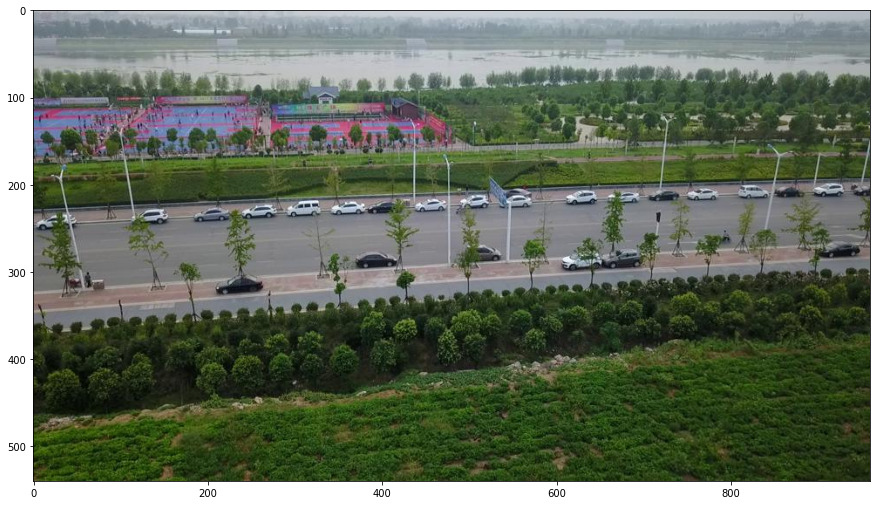

In [2]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('data/coco/train2017/0000003_00231_d_0000016.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the kitti annotation format into the middle format. In this tutorial we choose to convert them in **`load_annotations`** function in a newly implemented **`KittiTinyDataset`**.

Let's take a loot at the annotation txt file.



In [3]:
# Check the label of a single image
!cat data/coco/annotationsxml/0000002_00448_d_0000015.xml

<annotation>
	<folder>images</folder>
	<filename>0000002_00448_d_0000015.jpg</filename>
	<path>/home/htang/1Projects/D2Det-mmdet2.1/data/coco/images/0000002_00448_d_0000015.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>960</width>
		<height>540</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>car</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>93</xmin>
			<ymin>388</ymin>
			<xmax>167</xmax>
			<ymax>427</ymax>
		</bndbox>
	</object>
	<object>
		<name>car</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>195</xmin>
			<ymin>356</ymin>
			<xmax>256</xmax>
			<ymax>399</ymax>
		</bndbox>
	</object>
	<object>
		<name>car</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>96</xmin>
			<ymin>452</ymin>
			<xmax>177</xmax>
			<ymax>498</ymax>
		</bndbox>

According to the KITTI's documentation, the first column indicates the class of the object, and the 5th to 8th columns indicates the bboxes. We need to read annotations of each image and convert them into middle format MMDetection accept is as below:

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray> (n, 4),
            'labels': <np.ndarray> (n, ),
            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)
            'labels_ignore': <np.ndarray> (k, 4) (optional field)
        }
    },
    ...
]
```

In [4]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class VisDroneDataset(CustomDataset):

    CLASSES = ('car', 'truck', 'bus')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('images', 'VisDronetxt')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [5]:
from mmcv import Config
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [6]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VisDroneDataset'
cfg.data_root = 'data/coco/'

cfg.data.train.type = 'VisDroneDataset'
cfg.data.train.data_root ='data/coco/'
cfg.data.train.ann_file = 'ImageSets/Main/train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'VisDroneDataset'
cfg.data.val.data_root = 'data/coco/'
cfg.data.val.ann_file = 'ImageSets/Main/val.txt'
cfg.data.val.img_prefix = 'images'

cfg.data.test.type = 'VisDroneDataset'
cfg.data.test.data_root = 'data/coco/'
cfg.data.test.ann_file = 'ImageSets/Main/val.txt'
cfg.data.test.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to

# use the mask branch

cfg.load_from = './work_dirs/faster_rcnn/epoch_400.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/faster_rcnn'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None

#iter100,打印一次loss, loss_cls, loss_bbox, acc结果, 一个epoch 141 iter则一个epoch打印1次，1410iter打印10次
cfg.log_config.interval = 100

#设置评估指标coco-style使用bbox, voc-style使用mAP
cfg.evaluation.metric = 'mAP'
#设置评估模型的epoch数
cfg.evaluation.interval = 5
#设置保存checkpoints的epoch数
cfg.checkpoint_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    pretrained='open-mmlab://detectron2/resnet50_caffe',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        los

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [7]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/home/htang/1Projects/mmdetection-master/mmdet/datasets/custom.py:153: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
2020-11-21 04:22:23,708 - mmdet - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
2020-11-21 04:22:23,838 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias

2020-11-21 04:22:28,072 - mmdet - INFO - load checkpoint from ./work_dirs/faster_rcnn/epoch_400.pth
2020-11-21 04:22:28,420 - mmdet - INFO - Start running, host: root@x, work_dir: /home/htang/1Projects/mmdetection-master/work_dirs/faster_rcnn
2020-11-21 04:22:28,420 - mmdet - INFO - workflow: [('train', 1)], max: 10 epochs
2020-11-21 04:22:33,444 - mmdet - INFO - Epoch [1][5/141]	lr: 2.500e-03, eta: 0:22:15, time: 0.951, data_time: 0.436, memory: 3497, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0229, loss_cls: 0.0187, acc: 99.1992, loss_bbox: 0.0631

2020-11-21 04:23:55,678 - mmdet - INFO - Epoch [2][20/141]	lr: 2.500e-03, eta: 0:11:10, time: 0.502, data_time: 0.047, memory: 3716, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0215, loss_cls: 0.0343, acc: 98.4766, loss_bbox: 0.0918, loss: 0.1490
2020-11-21 04:23:58,286 - mmdet - INFO - Epoch [2][25/141]	lr: 2.500e-03, eta: 0:11:07, time: 0.528, data_time: 0.054, memory: 3716, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0312, loss_cls: 0.0253, acc: 98.8672, loss_bbox: 0.0939, loss: 0.1515
2020-11-21 04:24:00,976 - mmdet - INFO - Epoch [2][30/141]	lr: 2.500e-03, eta: 0:11:04, time: 0.521, data_time: 0.047, memory: 3716, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0311, loss_cls: 0.0287, acc: 98.8086, loss_bbox: 0.1051, loss: 0.1673
2020-11-21 04:24:03,669 - mmdet - INFO - Epoch [2][35/141]	lr: 2.500e-03, eta: 0:11:01, time: 0.541, data_time: 0.064, memory: 3716, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0228, loss_cls: 0.0204, acc: 99.1797, loss_bbox: 0.0894, loss: 0.1331
2020-11-21 04:24:06,334 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 7.8 task/s, elapsed: 9s, ETA:     0s

2020-11-21 04:25:07,748 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1646 | 0.903  | 0.891 |
| truck | 88   | 139  | 0.682  | 0.561 |
| bus   | 83   | 110  | 0.747  | 0.693 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.715 |
+-------+------+------+--------+-------+
2020-11-21 04:25:07,749 - mmdet - INFO - Epoch(val) [2][141]	mAP: 0.7152
2020-11-21 04:25:12,674 - mmdet - INFO - Epoch [3][5/141]	lr: 2.500e-03, eta: 0:10:01, time: 0.930, data_time: 0.429, memory: 3716, loss_rpn_cls: 0.0044, loss_rpn_bbox: 0.0303, loss_cls: 0.0219, acc: 99.0625, loss_bbox: 0.0867, loss: 0.1433
2020-11-21 04:25:15,329 - mmdet - INFO - Epoch [3][10/141]	lr: 2.500e-03, eta: 0:09:58, time: 0.530, data_time: 0.058, memory: 3716, loss_rpn_cls: 0.0044, loss_rpn_bbox: 0.0314, loss_cls: 0.0250, acc: 99.0234, loss_bbox: 0.0976, loss: 0.1584
2020-11-21 04:25:17,785 - mmdet -

2020-11-21 04:26:38,824 - mmdet - INFO - Epoch [4][25/141]	lr: 2.500e-03, eta: 0:08:33, time: 0.561, data_time: 0.058, memory: 3716, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0354, loss_cls: 0.0301, acc: 98.7891, loss_bbox: 0.1030, loss: 0.1701
2020-11-21 04:26:41,464 - mmdet - INFO - Epoch [4][30/141]	lr: 2.500e-03, eta: 0:08:31, time: 0.522, data_time: 0.051, memory: 3716, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0327, loss_cls: 0.0484, acc: 97.9492, loss_bbox: 0.1172, loss: 0.1993
2020-11-21 04:26:44,084 - mmdet - INFO - Epoch [4][35/141]	lr: 2.500e-03, eta: 0:08:28, time: 0.524, data_time: 0.057, memory: 3716, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0334, loss_cls: 0.0357, acc: 98.4961, loss_bbox: 0.0987, loss: 0.1691
2020-11-21 04:26:46,672 - mmdet - INFO - Epoch [4][40/141]	lr: 2.500e-03, eta: 0:08:25, time: 0.517, data_time: 0.057, memory: 3716, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0347, loss_cls: 0.0316, acc: 98.7305, loss_bbox: 0.1147, loss: 0.1820
2020-11-21 04:26:49,313 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.1 task/s, elapsed: 9s, ETA:     0s

2020-11-21 04:27:47,348 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1650 | 0.906  | 0.895 |
| truck | 88   | 121  | 0.648  | 0.550 |
| bus   | 83   | 125  | 0.795  | 0.745 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.730 |
+-------+------+------+--------+-------+
2020-11-21 04:27:47,349 - mmdet - INFO - Epoch(val) [4][141]	mAP: 0.7300
2020-11-21 04:27:52,148 - mmdet - INFO - Epoch [5][5/141]	lr: 2.500e-03, eta: 0:07:28, time: 0.906, data_time: 0.430, memory: 3822, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0209, loss_cls: 0.0366, acc: 98.5742, loss_bbox: 0.0854, loss: 0.1439
2020-11-21 04:27:54,732 - mmdet - INFO - Epoch [5][10/141]	lr: 2.500e-03, eta: 0:07:25, time: 0.517, data_time: 0.057, memory: 3822, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0368, loss_cls: 0.0311, acc: 98.5547, loss_bbox: 0.1057, loss: 0.1753
2020-11-21 04:27:57,099 - mmdet -

2020-11-21 04:29:17,469 - mmdet - INFO - Epoch [6][25/141]	lr: 2.500e-03, eta: 0:06:00, time: 0.527, data_time: 0.054, memory: 3822, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0186, loss_cls: 0.0334, acc: 98.6328, loss_bbox: 0.0847, loss: 0.1371
2020-11-21 04:29:20,042 - mmdet - INFO - Epoch [6][30/141]	lr: 2.500e-03, eta: 0:05:58, time: 0.504, data_time: 0.046, memory: 3822, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0179, loss_cls: 0.0315, acc: 98.5938, loss_bbox: 0.0787, loss: 0.1288
2020-11-21 04:29:22,694 - mmdet - INFO - Epoch [6][35/141]	lr: 2.500e-03, eta: 0:05:55, time: 0.537, data_time: 0.058, memory: 3822, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0378, loss_cls: 0.0260, acc: 98.8672, loss_bbox: 0.1047, loss: 0.1700
2020-11-21 04:29:25,295 - mmdet - INFO - Epoch [6][40/141]	lr: 2.500e-03, eta: 0:05:52, time: 0.513, data_time: 0.051, memory: 3822, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0255, loss_cls: 0.0212, acc: 99.2188, loss_bbox: 0.0867, loss: 0.1341
2020-11-21 04:29:27,955 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.1 task/s, elapsed: 9s, ETA:     0s

2020-11-21 04:30:26,074 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1647 | 0.905  | 0.895 |
| truck | 88   | 136  | 0.693  | 0.587 |
| bus   | 83   | 119  | 0.783  | 0.716 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.733 |
+-------+------+------+--------+-------+
2020-11-21 04:30:26,075 - mmdet - INFO - Epoch(val) [6][141]	mAP: 0.7326
2020-11-21 04:30:30,905 - mmdet - INFO - Epoch [7][5/141]	lr: 2.500e-04, eta: 0:04:56, time: 0.912, data_time: 0.426, memory: 3822, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0325, loss_cls: 0.0247, acc: 98.9258, loss_bbox: 0.1049, loss: 0.1636
2020-11-21 04:30:33,438 - mmdet - INFO - Epoch [7][10/141]	lr: 2.500e-04, eta: 0:04:53, time: 0.506, data_time: 0.057, memory: 3822, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0327, loss_cls: 0.0275, acc: 99.0430, loss_bbox: 0.0983, loss: 0.1597
2020-11-21 04:30:35,780 - mmdet -

2020-11-21 04:31:58,581 - mmdet - INFO - Epoch [8][25/141]	lr: 2.500e-04, eta: 0:03:31, time: 0.530, data_time: 0.055, memory: 3822, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0262, loss_cls: 0.0228, acc: 99.1797, loss_bbox: 0.0808, loss: 0.1320
2020-11-21 04:32:01,175 - mmdet - INFO - Epoch [8][30/141]	lr: 2.500e-04, eta: 0:03:29, time: 0.507, data_time: 0.047, memory: 3822, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0239, loss_cls: 0.0247, acc: 99.0039, loss_bbox: 0.0802, loss: 0.1305
2020-11-21 04:32:03,932 - mmdet - INFO - Epoch [8][35/141]	lr: 2.500e-04, eta: 0:03:26, time: 0.549, data_time: 0.059, memory: 3822, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0167, loss_cls: 0.0220, acc: 99.0430, loss_bbox: 0.0620, loss: 0.1041
2020-11-21 04:32:06,678 - mmdet - INFO - Epoch [8][40/141]	lr: 2.500e-04, eta: 0:03:23, time: 0.549, data_time: 0.062, memory: 3822, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0161, loss_cls: 0.0225, acc: 98.9453, loss_bbox: 0.0654, loss: 0.1064
2020-11-21 04:32:09,590 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.0 task/s, elapsed: 9s, ETA:     0s

2020-11-21 04:33:08,992 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1661 | 0.909  | 0.898 |
| truck | 88   | 129  | 0.705  | 0.602 |
| bus   | 83   | 115  | 0.747  | 0.685 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.728 |
+-------+------+------+--------+-------+
2020-11-21 04:33:08,994 - mmdet - INFO - Epoch(val) [8][141]	mAP: 0.7282
2020-11-21 04:33:13,864 - mmdet - INFO - Epoch [9][5/141]	lr: 2.500e-04, eta: 0:02:27, time: 0.923, data_time: 0.434, memory: 3822, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0171, loss_cls: 0.0249, acc: 98.9844, loss_bbox: 0.0699, loss: 0.1123
2020-11-21 04:33:16,505 - mmdet - INFO - Epoch [9][10/141]	lr: 2.500e-04, eta: 0:02:25, time: 0.524, data_time: 0.054, memory: 3822, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0190, loss_cls: 0.0160, acc: 99.3164, loss_bbox: 0.0624, loss: 0.0985
2020-11-21 04:33:18,977 - mmdet -

2020-11-21 04:34:40,027 - mmdet - INFO - Epoch [10][25/141]	lr: 2.500e-05, eta: 0:01:01, time: 0.526, data_time: 0.054, memory: 3822, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0144, loss_cls: 0.0180, acc: 99.3164, loss_bbox: 0.0564, loss: 0.0894
2020-11-21 04:34:42,584 - mmdet - INFO - Epoch [10][30/141]	lr: 2.500e-05, eta: 0:00:59, time: 0.502, data_time: 0.047, memory: 3822, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0182, loss_cls: 0.0260, acc: 99.0234, loss_bbox: 0.0795, loss: 0.1242
2020-11-21 04:34:45,235 - mmdet - INFO - Epoch [10][35/141]	lr: 2.500e-05, eta: 0:00:56, time: 0.529, data_time: 0.057, memory: 3822, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0147, loss_cls: 0.0212, acc: 99.1602, loss_bbox: 0.0594, loss: 0.0963
2020-11-21 04:34:47,895 - mmdet - INFO - Epoch [10][40/141]	lr: 2.500e-05, eta: 0:00:53, time: 0.526, data_time: 0.058, memory: 3822, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0210, loss_cls: 0.0204, acc: 99.1406, loss_bbox: 0.0692, loss: 0.1119
2020-11-21 04:34:50,699 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.1 task/s, elapsed: 9s, ETA:     0s

2020-11-20 20:35:50,919 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1656 | 0.909  | 0.898 |
| truck | 88   | 131  | 0.693  | 0.595 |
| bus   | 83   | 119  | 0.795  | 0.726 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.740 |
+-------+------+------+--------+-------+
2020-11-20 20:35:50,920 - mmdet - INFO - Epoch(val) [10][141]	mAP: 0.7397


### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the detector we actually using is Faster R-CNN, the weights in mask branch, e.g. `roi_head.mask_head`, are `unexpected key in source state_dict` and not loaded.
The original Mask R-CNN is trained on COCO dataset which contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Mask R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

img = mmcv.imread('testImages/test.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


NameError: name 'mmcv' is not defined

# 计算bbox/mAP

In [3]:
%run tools/test.py ./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py work_dirs/faster_rcnn/epoch_400.pth  --out out/aver.pkl --eval bbox --show

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 2.8 task/s, elapsed: 25s, ETA:     0s
writing results to out/aver.pkl

Evaluating bbox...
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.32s).
Accumulating evaluation results...
DONE (t=0.06s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.725
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.601
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.318
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.568
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.501
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.580
Average Recall 

# 分析训练日志

plot curve of work_dirs/faster_rcnn/log.json, metric is loss_cls


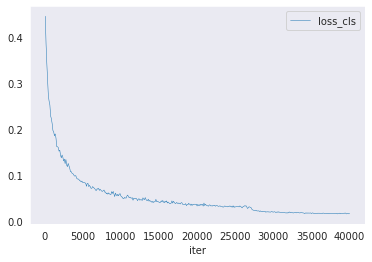

In [1]:
#绘制分类损失
%run tools/analyze_logs.py plot_curve work_dirs/faster_rcnn/log.json --keys loss_cls --legend loss_cls

plot curve of work_dirs/faster_rcnn/log.json, metric is loss_bbox


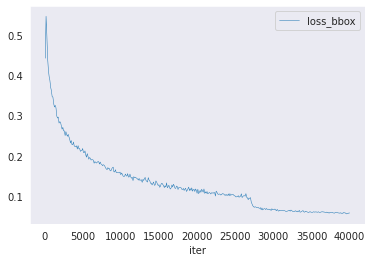

In [2]:
#回归损失
%run tools/analyze_logs.py plot_curve work_dirs/faster_rcnn/log.json --keys loss_bbox --legend loss_bbox

plot curve of work_dirs/faster_rcnn/log.json, metric is loss


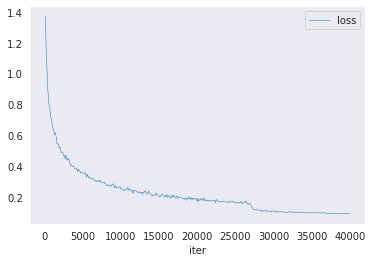

In [3]:
#总损失
%run tools/analyze_logs.py plot_curve work_dirs/faster_rcnn/log.json --keys loss --legend loss

plot curve of work_dirs/faster_rcnn/log.json, metric is acc


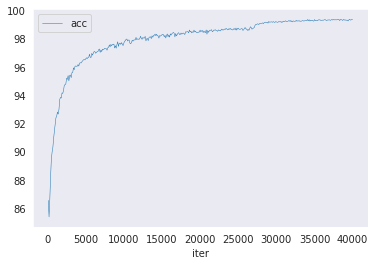

In [4]:
#精度
%run tools/analyze_logs.py plot_curve work_dirs/faster_rcnn/log.json --keys acc --legend acc

plot curve of work_dirs/faster_rcnn/log.json, metric is loss_cls
plot curve of work_dirs/faster_rcnn/log.json, metric is loss_bbox
plot curve of work_dirs/faster_rcnn/log.json, metric is loss
save curve to: work_dirs/faster_rcnn/losses.pdf
plot curve of work_dirs/faster_rcnn/log.json, metric is acc
save curve to: work_dirs/faster_rcnn/acc.pdf


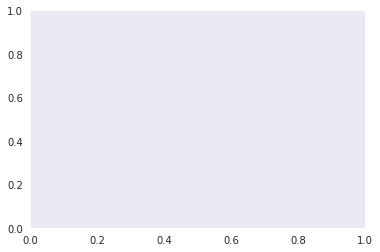

In [5]:
#多曲线保存为pdf输出
%run tools/analyze_logs.py plot_curve work_dirs/faster_rcnn/log.json --keys loss_cls loss_bbox loss --out work_dirs/faster_rcnn/losses.pdf
%run tools/analyze_logs.py plot_curve work_dirs/faster_rcnn/log.json --keys acc --out work_dirs/faster_rcnn/acc.pdf